In [5]:
# Make sure to install GPUtil first
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    if torch.cuda.is_available():
        print("Initial GPU Usage:")
        gpu_usage()

        # Clear PyTorch cache
        torch.cuda.empty_cache()

        # Clear Numba cache
        cuda.select_device(0)
        cuda.close()
        cuda.select_device(0)

        print("GPU Usage after emptying the cache:")
        gpu_usage()
    else:
        print("No GPU available or CUDA is not enabled.")

free_gpu_cache()


Initial GPU Usage:
| ID | GPU | MEM |
------------------
|  0 | 38% |  3% |
GPU Usage after emptying the cache:
| ID | GPU | MEM |
------------------
|  0 | 41% |  5% |


In [6]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:
import tensorflow as tf
import gc
tf.keras.backend.clear_session()
gc.collect()


0

In [8]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("simranvolunesia/pest-dataset")

# print("Path to dataset files:", path)


In [9]:
# import zipfile
# import os

# # Replace 'your_file.zip' with your actual zip file name
# with zipfile.ZipFile('/content/pest.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/your_folder')

# # Verify the contents
# os.listdir('/content/your_folder')

Found 2700 files belonging to 9 classes.
(64, 256, 256, 3)
[2 1 7 2 6 1 2 5 7 7 3 6 0 3 0 5 4 3 5 5 7 3 1 8 8 1 0 2 2 4 1 4 4 1 7 7 7
 6 1 1 0 3 8 7 1 8 3 4 4 7 2 5 6 0 7 7 4 6 3 4 2 5 7 4]


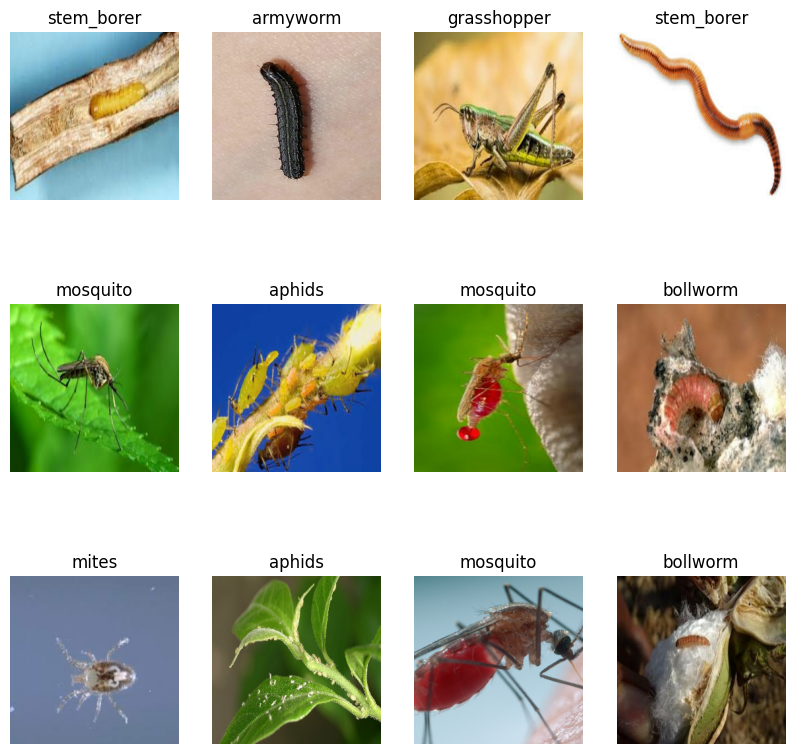

In [10]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
BATCH_SIZE = 64
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50
dataset = tf.keras.preprocessing.image_dataset_from_directory(
"pest/train",
 seed=123,
 shuffle=True,
 image_size=(IMAGE_SIZE,IMAGE_SIZE),
 batch_size=BATCH_SIZE
)
class_names = dataset.class_names
class_names=['aphids','armyworm','beetle','bollworm','grasshopper','mites','mosquito','sawfly','stem_borer']
for image_batch, labels_batch in dataset.take(1):
 print(image_batch.shape)
 print(labels_batch.numpy())
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
  for i in range(12):
     ax = plt.subplot(3, 4, i + 1)
     plt.imshow(image_batch[i].numpy().astype("uint8"))
     plt.title(class_names[labels_batch[i]])
     plt.axis("off")

In [11]:
len(dataset)
train_size = 0.8
len(dataset)*train_size
train_ds = dataset.take(54)
len(train_ds)
test_ds = dataset.skip(54)
len(test_ds)
val_size=0.1
len(dataset)*val_size
val_ds = test_ds.take(6)
len(val_ds)
test_ds = test_ds.skip(6)
len(test_ds)
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.2,test_split=0.1,
shuffle=True, shuffle_size=10000):
 assert (train_split + test_split + val_split) == 1
 ds_size = len(ds)
 if shuffle:
     ds = ds.shuffle(shuffle_size, seed=12)
 train_size = int(train_split * ds_size)
 val_size = int(val_split * ds_size)

 train_ds = ds.take(train_size)
 val_ds = ds.skip(train_size).take(val_size)
 test_ds = ds.skip(train_size).skip(val_size)
 return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
len(train_ds)
len(val_ds)
len(test_ds)
train_ds =train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds =val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds =test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
resize_and_rescale = tf.keras.Sequential([
 layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
 layers.Rescaling(1./255),
])
data_augmentation = tf.keras.Sequential([
 layers.RandomFlip("horizontal_and_vertical"),
 layers.RandomRotation(0.2),
 layers.RandomZoom(0.2),
 layers.RandomContrast(0.2),
])
train_ds = train_ds.map(
lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 9
model = models.Sequential([
 resize_and_rescale,
 layers.Conv2D(32, kernel_size = (3,3), activation='relu',
input_shape=input_shape),
 layers.MaxPooling2D((2, 2)),
 layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
 layers.MaxPooling2D((2, 2)),
 layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
 layers.MaxPooling2D((2, 2)),
 layers.Conv2D(64, (3, 3), activation='relu'),
 layers.MaxPooling2D((2, 2)),
 layers.Conv2D(64, (3, 3), activation='relu'),
 layers.MaxPooling2D((2, 2)),
 layers.Flatten(),
 layers.Dense(128, activation='relu'),
layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)
model.summary()

c:\Python 3.7\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (64, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (64, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (64, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (64, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (64, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (64, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (64, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (64, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (64, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (64, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (64, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (64, 2304)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, 128)              │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (64, 9)                │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 426,377 (1.63 MB)

 Trainable params: 426,377 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
import os
import shutil
import random
import cv2
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau, TensorBoard, CSVLogger, EarlyStopping,ReduceLROnPlateau
save_weights_path = f"./cnn_12_layers/results/trash-model-weight.weights.h5"
csv_path = f"./cnn_12_layers/results/12_layers.csv"
log_dir = f"./cnn_12_layers/results/12_layers"
os.makedirs(f"./cnn_12_layers/results", exist_ok = True)
model_checkpoints = ModelCheckpoint(save_weights_path,
monitor='val_accuracy', verbose=1, save_weights_only=True,
save_best_only=True)
model_loggers = TensorBoard(log_dir=log_dir)
model_csvloggers = CSVLogger(csv_path, append=True)
early_stop_patience = 10
early_stop = EarlyStopping('val_accuracy',
patience=early_stop_patience)
reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.05, patience=
2, verbose=1)
callbacks = [early_stop, reduce_lr, model_checkpoints, model_loggers,
model_csvloggers]
model.compile(
 optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
 metrics=['accuracy']
)
history = model.fit(
 train_ds,
 batch_size=BATCH_SIZE,
 validation_data=val_ds,
 verbose=1,
 epochs=50,
)




Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.1167 - loss: 2.1948 - val_accuracy: 0.1621 - val_loss: 2.1897
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.1873 - loss: 2.1341 - val_accuracy: 0.1660 - val_loss: 2.0679
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.2252 - loss: 2.0763 - val_accuracy: 0.2285 - val_loss: 2.0359
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.2502 - loss: 2.0205 - val_accuracy: 0.2246 - val_loss: 1.9372
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.2552 - loss: 1.9528 - val_accuracy: 0.3008 - val_loss: 1.9278
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.2947 - loss: 1.9128 - val_accuracy: 0.2852 - val_loss: 1.8521
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.3253 - loss: 1.7748 - val_accuracy: 0.3672 - val_loss: 1.7409
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.3647 - loss: 1.6944 - val_accuracy: 0.3848 - val_loss:

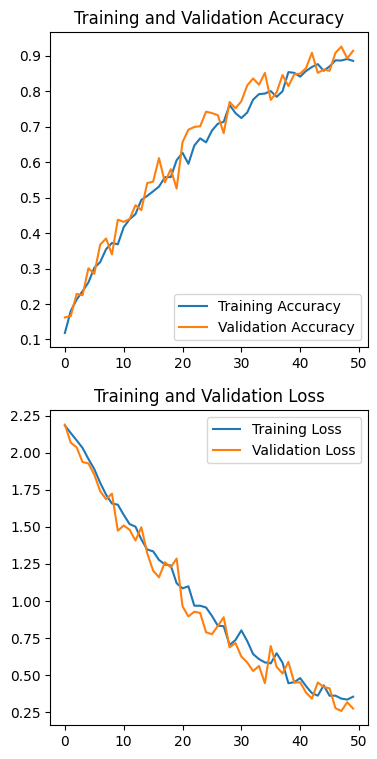

In [14]:
history
history.params
history.history.keys()
#dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
type(history.history['loss'])
len(history.history['loss'])
history.history['loss'][:5]
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(9, 9))
plt.subplot(2, 2, 1)
#plt.plot()
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 2, 3)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
!pip install scikit-learn


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step

Accuracy of CNN Model: 0.940625



Classification Report of CNN Model on Testing Set:


              precision    recall  f1-score   support

      aphids       0.88      1.00      0.94        29
    armyworm       0.92      0.88      0.90        41
      beetle       0.98      1.00      0.99        48
    bollworm       0.95      0.89      0.92        44
 grasshopper       1.00      0.94      0.97        32
       mites       0.96      0.92      0.94        25
    mosquito       0.97      0.95      0.96        38
      sawfly       0.93      0.93      0.93        29
  stem_borer       0.87      0.97      0.92        34

    accuracy                           0.94       320
   macro avg       0.94      0.94      0.94       320
weighted avg       0.94      0.94      0.94       320



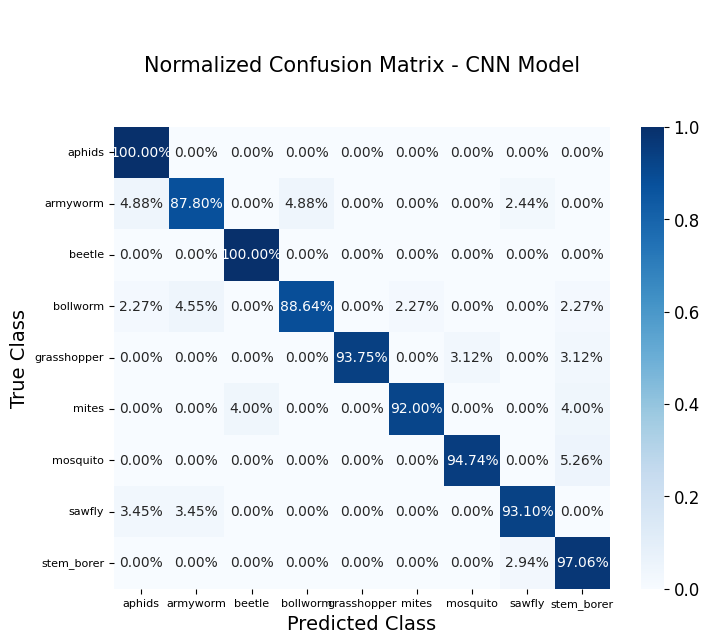

In [19]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
# Assuming class names are provided
class_names = ['aphids','armyworm','beetle','bollworm','grasshopper','mites','mosquito','sawfly','stem_borer']
# Convert test_ds to numpy arrays
x_test = []
y_test = []
for images, labels in test_ds:
 x_test.append(images.numpy())
 y_test.append(labels.numpy())
x_test = np.concatenate(x_test, axis=0)
y_test = np.concatenate(y_test, axis=0)
# Check if y_test is one-hot encoded
if y_test.ndim > 1 and y_test.shape[1] > 1:
 true_labels_test = np.argmax(y_test, axis=1)
else:
 true_labels_test = y_test
# Ensure true_labels_test and pred_labels_test are numpy arrays
true_labels_test = np.array(true_labels_test)
pred_labels_test = np.array(np.argmax(model.predict(x_test), axis=1))
# Accuracy
accuracy_on_test = accuracy_score(true_labels_test, pred_labels_test)
print(f"\nAccuracy of CNN Model: {accuracy_on_test}")
# Classification Report
print(f"\n\n\nClassification Report of CNN Model on Testing Set:\n\n")
class_report = classification_report(true_labels_test,
pred_labels_test, target_names=class_names)
print(class_report)
# Confusion Matrix
conf_matrix = confusion_matrix(true_labels_test, pred_labels_test,
normalize='true')
annotations = [['{:.2%}'.format(value) for value in row] for row in
conf_matrix]
# Plotting Confusion Matrix
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(conf_matrix, annot=annotations, fmt='',
cmap="Blues", xticklabels=class_names, yticklabels=class_names,
annot_kws={"size": 10})
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=8,
rotation=0)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=8  )
heatmap.collections[0].colorbar.ax.tick_params(labelsize=12)
plt.xlabel('Predicted Class', fontsize=14)
plt.ylabel('True Class', fontsize=14)
plt.title('\n\nNormalized Confusion Matrix - CNN Model\n\n', fontsize=15)
plt.show()

In [20]:
model.save('Pesttrained.h5')